<a href="https://colab.research.google.com/github/Kobajojn/FYRP_U-Net_Architecture/blob/main/U_net_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [77]:
!pip install tacoreader rasterio

2025-10-08 13:02:51,826 matplotlib.image WARNING:	Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3428].


Text(0.5, 1.0, 'Human label')

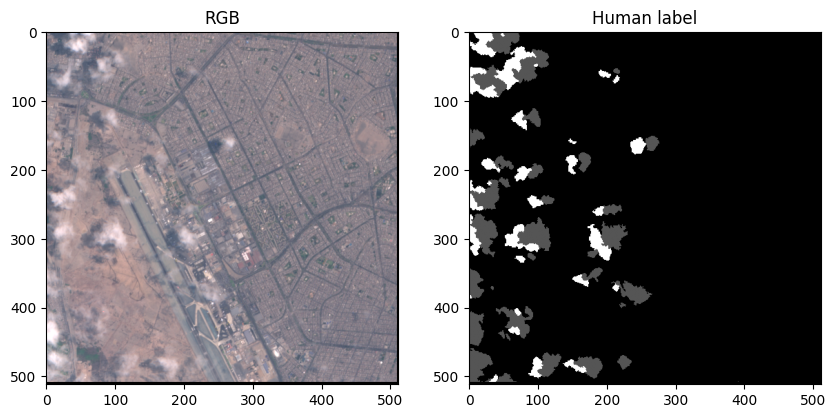

In [78]:
# @Setup and accessing CloudSEN12+
# REWRITE WHOLE SECTION - COPIED

import logging
import matplotlib.pyplot
import matplotlib.pyplot
import numpy
import tacoreader
import rasterio as rio
import torch
import torch.nn as nn

# initalise and set up the logger

# Select one image from the test dataset
ds = tacoreader.load("tacofoundation:cloudsen12-l1c")
subset = ds[(ds["tortilla:data_split"] == "test") & (ds["label_type"] == "high") & (ds["real_proj_shape"] == 509)] #splits the file into segments - rewrite - from tacoreader library

# Read only one sample
sample_idx = 271
s2_l1c = subset.read(sample_idx).read(0)
s2_label = subset.read(sample_idx).read(1)

# Retrieve the S2 data - EDIT TO BE MORE READABLE
with rio.open(s2_l1c), rio.open(s2_label):
    s2_l1c_data = rio.open(s2_l1c).read(window=rio.windows.Window(0, 0, 512, 512)) / 10_000   # (13, 512, 512) ndarray (numpy)
    s2_label_data = rio.open(s2_label).read(window=rio.windows.Window(0, 0, 512, 512))        #var is a string with links to hugging face

# Graphing image with human determined labels
datapoint_rgb = numpy.moveaxis(s2_l1c_data[[3, 2, 1]], 0, -1) * 3  #REWRITE - ensure that the dimensionality exploited is the colour channels #TODO understand technique
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(datapoint_rgb)
ax[0].set_title("RGB")
ax[1].imshow(s2_label_data[0], cmap="gray")
ax[1].set_title("Human label")

In [79]:
# set up logger application
logger = logging.getLogger(__name__)

logging.basicConfig(
    #filename = "logging.txt",  # logger is saved to file instead of value
    encoding = "ASCII",
    format = "%(asctime)s %(name)s %(levelname)s:\t%(message)s",
    level = logging.INFO,
    force = True
)

# Misc Functions

In [80]:
def tensor_info(tensor_input, tensor_name):
  """
  Prints off a list of the tensor's details including:  \
    Datatype, Shape, Size, and the device location stored in memory

  foward() Args:
    tensor_input (tensor) - tensor to be examined.
    tensor_name (string) - a string description of the tensor used for descriptive purposes

  return:
    None
  """
  logger.info(f"Tensor:\t\t\t{tensor_name}")
  logger.info(f"Output Datatype:\t{tensor_input.dtype}")
  logger.info(f"Output Shape:\t\t{tensor_input.shape}")
  logger.info(f"Output Size:\t\t{tensor_input.size()}")
  logger.info(f"Output Device:\t\t{tensor_input.device}"
      f"\n--------------------------------------------------------\n")
  return None

In [81]:
def mash_colour_channel(img):
  """
  Generate a greyscale image of a tensor with more than 3 colour/feature channels. \
    Use primarily for visualisation and debugging purposes of prior transformations.

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    None
  """
  # Temporary - converts from Tensor to numpy - TODO: understand why detach is needed
  img = img.detach().numpy()
  z_size = img.shape[0] # Gathers the size of the z or colour element

  # averages out the colour channel elementwise - main transformation of function
  img_no_colour = numpy.mean(a = img, axis = 0)

  # display image dimension characterisitics and print the image
  logger.info(f"The image resolution is {img_no_colour.shape}")
  logger.info(f"The number of colour channels are {z_size}")
  matplotlib.pyplot.gray() # place the image output into greyscale
  matplotlib.pyplot.imshow(img_no_colour)
  matplotlib.pyplot.show()
  return None

# Encoder Layer

In [82]:
device = 'cpu'

# ENCODER LAYER - going "down the U"; i.e decreasing the resolution at the for more colour channels

class conv_layer(nn.Module):
  """
  Decreases the spatial resolution of the image for more colour/feature channels.
    Used in both encoder and decoder segments.
    Applies a convolution (3x3) and ReLU to the image twice to the image.
    1x convolution reduces the resolution by 2 pixels and 2x the colour channels.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.
  foward() Args:
    img (tensor float32) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor float32) - The output image after transformations.
  """
  def __init__ (self, channels_in, up_sample = True): # Parameters go here!
    super().__init__()

    if up_sample:
      out_channels = channels_in * 2
    else:
      out_channels = int(channels_in / 2)

    # Convolution 1 - a sliding window function
    self.conv1 = nn.Conv2d(
        in_channels = channels_in,
        out_channels = out_channels,
        kernel_size = 3,
        stride = 1,
        # padding = 1,                    # padded with zeros to ensure dimensions are always even
        # padding_mode = 'zeros',         # [30] recommends an unpadded convolution
        # bias = True # defaults to True - is a learned bias to Output
        dtype = torch.float32
    )
    # Convolution 2 - a sliding window function
    self.conv2 = nn.Conv2d(
        in_channels = out_channels,
        out_channels = out_channels,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    )
    # Rectified Linear Unit 1 - A non-linear activation function
    self.relu = nn.ReLU()

  def forward(self, img):
    output = self.conv1(img)
    output = self.relu(output)
    output = self.conv2(output)
    output = self.relu(output)
    return output


class encoder_layer(nn.Module):
  """
  Decreases the spatial resolution of the image for more colour/feature channels.
    Main core segment of the encoder stage.
    Applies a convolution (3x3) and ReLU to the image twice then (2x2) pool to the image.

    1x pooling downsamples the resolution by x0.5.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.
  foward() Args:
    img (tensor float32) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    postpool_output (tensor float32) - The output image after pooling.
    prepool_output (tensor float32) - The output image before pooling. Used in concatenation.
  """
  def __init__ (self): # Parameters go here!
    super().__init__()

    # A 2x2 kernal is used, with a stride/offset of 2 pixels
    self.pooling = nn.MaxPool2d(
        kernel_size = (2, 2),
        stride = 2,
    )

  def forward(self, img, channels_in):
    conv_forward = conv_layer(channels_in = channels_in)
    output = conv_forward(img)

    prepool_output = output
    postpool_output = self.pooling(output) # Final transformation to image

    return postpool_output, prepool_output


# Decoder Layer

In [83]:
# DECODER LAYER - going "up the U"; i.e increasing the resolution at the expense of less colour channels

class decoder_layer(nn.Module):
  """
  Increases the spatial resolution of the image for less colour/feature channels.
    Apply a (2x2) "deconvolution" transformation to counteract the impacts of pooling and convolution.
    Then a "concatenation_feature()" is applied to double colour channel size.
    The main building block of the decoder side of the U-net model.
    1x deconvolution increases the resolution 2x and the colour channels by x0.5.
    1x "concatenation_features()" to the image (doubles colour channel)

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.

  crop_and_concat() Args:
    img_decoder (tensor float32) - Deconvoluted image from decoder side.
      Image format is [z, x, y] or [w, u, v].
      Only works if [x, y] dimensions are EVEN.
    img_encoder_skip (tensor float32) - Pooled image from encoder side. Larger than img_deconv
      Image format is [z, x, y] or [w, u, v]

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor) - The increased spatial resolution image.
  """
  def __init__ (self, channels_deconv_in):
    super().__init__()

    self.deconv1 = nn.ConvTranspose2d(
        in_channels = channels_deconv_in,
        out_channels = int(channels_deconv_in / 2),
        kernel_size = [2, 2], # Deconvolute the image with a 2x2 kernal
        stride = 2,           # to significantly increase the resolution
        dtype = torch.float32
    )

  def crop_and_concat(self, img_decoder, img_encoder_skip):
    """
    Doubles the feature channels of its input image.
      Crops prepool_output from the encoder layer and then concatenates its colour/
      feature channels with the decoder's respective deconvoluted image.

    Args:
      img_decoder (tensor float32) - Deconvoluted image from decoder side.
        Image format is [z, x, y] or [w, u, v].
        Only works if [x, y] dimensions are EVEN.
      img_encoder_skip (tensor float32) - Pooled image from encoder side. Larger than img_deconv
        Image format is [z, x, y] or [w, u, v]

    Returns:
      img_concat (tensor float32) - image with double the inputs colour channels
    """
    # Determining the range of the cropping
    size_difference =  img_encoder_skip.shape[1] - img_decoder.shape[1]
    logger.debug(f"size_difference = {size_difference}")
    logger.debug(f"img_encoder_skip.shape = {img_decoder.shape}")
    logger.debug(f"img_decoder.shape = {img_decoder.shape}")

    lower_range = int(size_difference / 2)
    upper_range = img_decoder.shape[1] + lower_range

    # Only works if dimensions are even
    if size_difference % 2 == 0:
      logger.debug(f"The image dimensions are EVEN. Thus cropping can be applied.")

      # Crop the encoded image to fit the resolution of the reduced (in dimensions) decoded image
      img_encoder_crop = img_encoder_skip[:, lower_range:upper_range, lower_range:upper_range]
      # tensor_info(img_decoder, "[ORIGINAL] img_decoder")
      # tensor_info(img_encoder_crop, "[CROPPED] img_encoder_crop")

      # concatenate the colour/feature channels of the encoder and decoder imgs.
      img_concat = torch.cat(tensors = (img_decoder, img_encoder_crop), dim = 0)
      # tensor_info(img_concat, "[COMBINED] img_concat (combined colour channels)")
      # mash_colour_channel(img_concat)

      return img_concat

    else:
      logger.info(f"The image dimensions are ODD. Thus cropped can NOT be applied."
        f"Please crop the image for a EVEN dimension.")
      return None

  def forward(self, img_decoder, img_encoder_skip, channels_in):
    # deconvolute (decrease features, increasing x,y size) + crop and concatenate (x2 feature channels)
    output = self.deconv1(img_decoder)
    output = self.crop_and_concat(img_decoder = output, img_encoder_skip = img_encoder_skip)

    # Apply 2x convolutions + 2x ReLU
    conv_layer_1 = conv_layer(channels_in = channels_in, up_sample = False)
    output = conv_layer_1(output)
    return output

# Bringing it all together

In [84]:
""" ---VARIABLE NAMING NOMENCLATURE:---
- Alphabetical images correspond to which layer the image was generated on.
e.g. B_pooled is on layer 2.
- "X_pooled" are images generated with 2x2 pooling applied.
- "X_concat" are images generated before pooling. This are for concatenation later.
"""

class u_net(nn.Module):
  """
  Increases the spatial resolution of the image for less colour/feature channels.
    Applies the U-net architecture complete via prior defined piecemeal functions.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.

  crop_and_concat() Args:
    img_decoder (tensor float32) - Deconvoluted image from decoder side.
      Image format is [z, x, y] or [w, u, v].
      Only works if [x, y] dimensions are EVEN.

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor) - The increased spatial resolution image.
  """
  def __init__ (self, ):
    super().__init__()
    # ---------------------------------------------------------
    # Instantiate and initialise each layer
    # Encoder Layer instantiation
    self.encoder_layer_1 = encoder_layer().to(device)
    # Bottleneck Layer instantiation
    self.bottleneck_layer = conv_layer(channels_in = 208).to(device)
    # Decoders instantiation
    self.decoder_layer_0 = decoder_layer(channels_deconv_in = 416).to(device)
    self.decoder_layer_1 = decoder_layer(channels_deconv_in = 208).to(device)
    self.decoder_layer_2 = decoder_layer(channels_deconv_in = 104).to(device)
    self.decoder_layer_3 = decoder_layer(channels_deconv_in = 52).to(device)
    self.decoder_layer_4 = decoder_layer(channels_deconv_in = 26).to(device)
    # Final Layer instantiation
    self.final_layer = conv_layer(channels_in = 26, up_sample = False).to(device)
    # ---------------------------------------------------------
    # TODO - remove if unneeded - included as debug 08.10.2025
    self.flatten_final_layer = nn.Conv2d(
          in_channels = 13,
          out_channels = 1,
          kernel_size = 3,
          stride = 1,
    )

  def forward(self, img):

    # Apply image to instantiated layers
    # Encoder layer
    A_pooled, A_concat = self.encoder_layer_1(img, channels_in = 13)
    B_pooled, B_concat = self.encoder_layer_1(A_pooled, channels_in = 26)
    C_pooled, C_concat = self.encoder_layer_1(B_pooled, channels_in = 52)
    D_pooled, D_concat = self.encoder_layer_1(C_pooled, channels_in = 104)

    # Bottleneck layer
    E_bottleneck = self.bottleneck_layer(D_pooled)

    # Decoder Layer
    D_deconv = self.decoder_layer_0(
        img_decoder = E_bottleneck,
        img_encoder_skip = D_concat,
        channels_in = 416
    )
    C_deconv = self.decoder_layer_1(
        img_decoder = D_deconv,
        img_encoder_skip = C_concat,
        channels_in = 208
    )
    B_deconv = self.decoder_layer_2(
        img_decoder = C_deconv,
        img_encoder_skip = B_concat,
        channels_in = 104
    )
    A_deconv = self.decoder_layer_3(
        img_decoder = B_deconv,
        img_encoder_skip = A_concat,
        channels_in = 52
    )
    # Final Layer
    Final_output = self.final_layer(A_deconv)
    Final_output = self.flatten_final_layer(Final_output)
    return Final_output

2025-10-08 13:02:53,539 __main__ INFO:	The image resolution is (318, 318)
2025-10-08 13:02:53,540 __main__ INFO:	The number of colour channels are 1


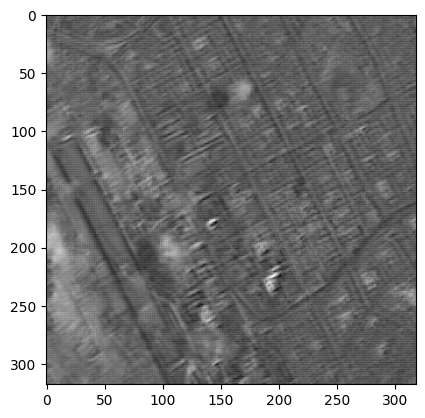

In [85]:
# Image preprocessing
s2_l1c_data_tensor = torch.from_numpy(s2_l1c_data)
s2_l1c_data_tensor = s2_l1c_data_tensor.to(torch.float32)
s2_l1c_data_tensor = s2_l1c_data_tensor.to(device)
# Crop image such that after 8 convolutions are 4 poolings, the dimensions are always even
s2_l1c_data_tensor = s2_l1c_data_tensor[:, 0:508, 0:508]

# Apply everything via the U-net architecture
u_net_arch = u_net()
img_out = u_net_arch(s2_l1c_data_tensor)

mash_colour_channel(img_out)

# Training Stage Sandpit

# New Section

In [86]:
# Sandpit - for debugging and troubleshooting
# Seed for randomness - keeps the initial parameter values consistent
torch.manual_seed(27)

# Sanity Check: Display u-net architecture's parameters
u_net_arch = u_net()
# Reinitialise u_net model
logger.debug(f"{list(u_net_arch_0.parameters()) = }")

# Training Stage

In [87]:
# PLACEHOLDER REMOVE ONCE OBSOLETE

# # Select one image from the test dataset
# ds = tacoreader.load("tacofoundation:cloudsen12-l1c")
# subset = ds[(ds["tortilla:data_split"] == "test") & (ds["label_type"] == "high") & (ds["real_proj_shape"] == 509)] #splits the file into segments - rewrite - from tacoreader library

# # Read only one sample
# sample_idx = 18
# s2_l1c = subset.read(sample_idx).read(0)   # string outlying the location of dataset
# s2_label = subset.read(sample_idx).read(1) # string outlying the location of dataset

# # Retrieve the S2 data - EDIT TO BE MORE READABLE
# # Builds the data into Colab
# with rio.open(s2_l1c), rio.open(s2_label):
#     s2_l1c_data = rio.open(s2_l1c).read(window=rio.windows.Window(0, 0, 512, 512)) / 10_000   # (13, 512, 512) ndarray (numpy)
#     s2_label_data = rio.open(s2_label).read(window=rio.windows.Window(0, 0, 512, 512))        #var is a string with links to hugging face

# # Graphing image with human determined labels
# datapoint_rgb = numpy.moveaxis(s2_l1c_data[[3, 2, 1]], 0, -1) * 3  #REWRITE - ensure that the dimensionality exploited is the colour channels #TODO understand technique
# fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(datapoint_rgb)
# ax[0].set_title("RGB")
# ax[1].imshow(s2_label_data[0], cmap="gray")
# ax[1].set_title("Human label")


In [88]:
# Preparation for auto iterating and downloading requesite data
l1c_fileNames = [
    "cloudsen12-l1c.0000.part.taco", # Installed - 2025.10.01
    "cloudsen12-l1c.0001.part.taco", # Installed - 2025.10.01
    "cloudsen12-l1c.0002.part.taco", # --
    "cloudsen12-l1c.0003.part.taco", # --
    "cloudsen12-l1c.0004.part.taco"  # --
  ]

from huggingface_hub import hf_hub_download
import os.path

# Searches for imported datasets. If none are found download
if os.path.isfile("/content/datasets/cloudsen12-l1c.0000.part.taco") == False:
  logger.info(f"The requisite datasets have not been installed.\n\t\t\t\t\t"
      "Please wait until the datasets is been installed from huggingface.\n\t\t\t\t\t"
      "This will take a long time approximately 5+ minutes")

  # 20GB download requires significant time - execute sparingly takes roughly 5 minutes to fully execute
  # Downloads data from huggingface and stores it in Colab file system which is reset on every startup
  dataset_0 = hf_hub_download(
      "tacofoundation/cloudsen12",
      "cloudsen12-l1c.0000.part.taco",
      repo_type = "dataset",
      revision = "f9490f7de11b4f387f72ef800e73ccbb754711de",
      local_dir = "/content/datasets" # Path to save dataset on Colab
  )
  logger.info(f"cloudsen12-l1c.0000.part.taco has been installed.")

  # dataset_1 = hf_hub_download(
  #     "tacofoundation/cloudsen12",
  #     "cloudsen12-l1c.0001.part.taco",
  #     repo_type = "dataset",
  #     revision = "f9490f7de11b4f387f72ef800e73ccbb754711de",
  #     local_dir = "/content/datasets" # Path to save dataset on Colab
  # )
  # logger.info(f"cloudsen12-l1c.0001.part.taco has been installed.")
  logger.info(f"The requisite datasets have been installed.")
else:
  logger.info(f"The requisite datasets have already been been installed.\n\t\t\t\t\t"
      "No further action is required.")
  # Ensure that the file is referenced in the local variable memory - TODO
  #with open("/content/datasets/cloudsen12-l1c.0000.part.taco") as file:
  #  exec(dataset1 = file)

2025-10-08 13:02:53,884 __main__ INFO:	The requisite datasets have already been been installed.
					No further action is required.


In [89]:
DATA = tacoreader.load(file = ["/content/datasets/cloudsen12-l1c.0000.part.taco", "/content/datasets/cloudsen12-l1c.0001.part.taco"])
# Splits the data into differing segments - used to seperate training and testing data


# TODO determine how to use this item - uses the tortilla data format
SUB_DATA = DATA[(DATA["tortilla:data_split"] == "test") & (DATA["label_type"] == "high") & (DATA["real_proj_shape"] == 508)]

Error processing file /content/datasets/cloudsen12-l1c.0001.part.taco: File does not exist or unsupported protocol: /content/datasets/cloudsen12-l1c.0001.part.taco. Supported protocols: s3, gs, az, oss, swift, http, https, ftp, and hf.


In [90]:
# Read a sample
sample_idx = 500 # Just change this!
lr = DATA.read(sample_idx).read(0)
hr = DATA.read(sample_idx).read(1)

# Retrieve the data
with rio.open(lr) as src, rio.open(hr) as dst:
    lr_data = src.read([4, 3, 2],window=rio.windows.Window(0, 0, 508, 508))
    hr_data = dst.read(window=rio.windows.Window(0, 0, 508, 508))

# mash_colour_channel(torch.from_numpy(lr_data))

In [91]:
def extract_data(sample_idx):
  # Reads only 1 sample from the saved DATA dataset
  # Cannot use the SUB_DATA variable for some reason
  img_data = DATA.read(sample_idx).read(0)
  lbl_data = DATA.read(sample_idx).read(1)

  # Retrieve the data
  # with rio.open(img_data) as src, rio.open(lbl_data) as dst:
      # s2_l1c_data = src.read([4, 3, 2],window = rio.windows.Window(0, 0, 512, 512))
      # s2_label_data = dst.read(window=rio.windows.Window(0, 0, 512, 512))

  with rio.open(img_data), rio.open(lbl_data):
    # Image input is 508x508 pixels so that u-net works best
    s2_l1c_data = rio.open(img_data).read(window=rio.windows.Window(0, 0, 508, 508)) / 10_000  # (13, 512, 512) ndarray (numpy)
    s2_label_data = rio.open(lbl_data).read(window=rio.windows.Window(0, 0, 508, 508))

  # Output relevant datasets
  return s2_l1c_data, s2_label_data


# img, label = extract_data(sample_idx = 4)
# mash_colour_channel(torch.from_numpy(img))
# mash_colour_channel(torch.from_numpy(label))

# img, label = extract_data(sample_idx = 7)
# mash_colour_channel(torch.from_numpy(img))
# mash_colour_channel(torch.from_numpy(label))

In [92]:
# The code done here follows the example methodologies shown in introduction to PyTorch

# Problem breakdown and requirements:

# Need to import training data
# -> breakdown into training and testing datasets
# -> datasets must be cropped and converted into valid filetype
# Need to import labels
# -> datatype?
# -> labels must be cropped and converted into valid filetype

# Need to evaluate success and labels

# WORK IN PROGRESS
# Define the working datasets:
# TODO CHECK DIMENSIONS
# imported datasets are: img [z,x,y,i?], labels [x,y,i?]

# Relies on assumptions of the quality of the imported data

# PLACEHOLDER
# img_in = s2_l1c_data
# label_in = s2_label_data

# Train and testing ratio
DATASET_AMOUNT = 10
tt_ratio = 0.8
TRAIN_AMOUNT = int(DATASET_AMOUNT * tt_ratio)
TEST_AMOUNT = DATASET_AMOUNT - TRAIN_AMOUNT

# Preallocate memory for traing and testing datasets
train_img = numpy.empty(shape = (TRAIN_AMOUNT, 13, 508, 508))
train_img.fill(None)

train_label = numpy.empty(shape = (TRAIN_AMOUNT, 508, 508))
train_label.fill(None)

test_img = numpy.empty(shape = (TEST_AMOUNT, 13, 508, 508,))
test_img.fill(None)

test_label = numpy.empty(shape = (TEST_AMOUNT, 508, 508,))
test_label.fill(None)


for i in range(DATASET_AMOUNT):
  img_in, label_in = extract_data(sample_idx = i)

  # DEBUGGING image retrieval
  # mash_colour_channel(torch.from_numpy(label_in)) # comment out - for testing purposes TODO

  # store into training and testing
  if i < TRAIN_AMOUNT:
    train_img[i][:][:][:] = img_in
    train_label[i][:][:] = label_in
    logger.debug(f"{i} train")
  else:
    test_img[i - TRAIN_AMOUNT][:][:][:]  = img_in
    test_label[i  - TRAIN_AMOUNT][:][:] = label_in
    logger.debug(f"{i} test")

# Convert to tensors!
train_img = torch.from_numpy(train_img)
train_label = torch.from_numpy(train_label)
test_img = torch.from_numpy(test_img)
test_label = torch.from_numpy(test_label)
# Convert to standard float32 tensors!
train_img = train_img.to(torch.float32)
train_label = train_label.to(torch.float32)
test_img = test_img.to(torch.float32)
test_label = test_label.to(torch.float32)

# Resulting tensors
tensor_info(train_img, "combined train_img data")
tensor_info(train_label, "combined train_label data")
tensor_info(test_img, "combined test_img data")
tensor_info(train_label, "combined train_label data")

# CONVERT TO FLOAT16!
# -----------------------------------------------------------------------------------------------------------
# # Accessing data recommendations: "https://colab.research.google.com/drive/1U9n40rwdnn73bdWruONA3hIs1-H3f74Q"

2025-10-08 13:02:55,553 __main__ INFO:	Tensor:			combined train_img data
2025-10-08 13:02:55,554 __main__ INFO:	Output Datatype:	torch.float32
2025-10-08 13:02:55,556 __main__ INFO:	Output Shape:		torch.Size([8, 13, 508, 508])
2025-10-08 13:02:55,558 __main__ INFO:	Output Size:		torch.Size([8, 13, 508, 508])
2025-10-08 13:02:55,559 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-08 13:02:55,560 __main__ INFO:	Tensor:			combined train_label data
2025-10-08 13:02:55,561 __main__ INFO:	Output Datatype:	torch.float32
2025-10-08 13:02:55,562 __main__ INFO:	Output Shape:		torch.Size([8, 508, 508])
2025-10-08 13:02:55,563 __main__ INFO:	Output Size:		torch.Size([8, 508, 508])
2025-10-08 13:02:55,563 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-08 13:02:55,564 __main__ INFO:	Tensor:			combined test_img data
2025-10-08 13:02:55,566 __main__ INFO:	Output Datatype:	torch.float32
2025-10-08

In [93]:
# For Debug
# todo - delete - [train_img, train_label, test_img, test_label]

def view_img(index_i, img_bundle, img_bundle_name):
  tensor_info(img_bundle[index_i][:][:][:], "img_bundle_name " + str(index_i))
  mash_colour_channel(img_bundle[index_i][:][:][:])

# view_img(1, train_img, "train_img")
# view_img(7, test_img, "test_img")
# view_img(19, test_img, "test_img")
# view_img(79, train_img, "train_img")

todo 02.10.2025 Thursday W8+1. Finalised 06.10.2025 Monday W9+1

Tried to save data the "stupidest" way possible. Iterate through a dataset - get data individually and then load data to a common array variable.

problems:
- incorrect datatype -  need a numpy object of a certain size/parameters
- need to collect imgs into single item - missing dimensions from bad appending
- need to seperate between training and testing - do after the main dataset variable is created.

- need to sort: geogrpahically, camerawise etc.

Codebase is completed under "stupid" method.

In [94]:

# # METHOD DOESN'T work it crashes the provider
# need to ensure prediction tensor is the same size as the input or it cropped


TRAINING_LENGTH = 1 # CONTROLS NUMBER OF TRAINING CYCLES


# Allow for parameters of model to be randomised.
weights = nn.Parameter(
    torch.randn(1, dtype = torch.float32),
    requires_grad = True
  )

# Model inferencing (making predictions) - TODO REMOVE IF UNNECESSARY
# with torch.inference_mode():
#   prediction = u_net_arch(img_test) # Can manually check the predictions

# loss and optimiser functions
loss_fn = nn.L1Loss() # TODO MAE loss is same as L1Loss
optimiser_fn = torch.optim.SGD(
    params = u_net_arch.parameters(), # parameters to be optimised
    lr = 0.01 # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))
)

# location and storage of loss values

for epoch in range(TRAINING_LENGTH):
  u_net_arch.train() # In Training Mode - Default

  label_predict = u_net_arch(train_img[epoch][:][:][:]) # intiial forward pass of model
  # DEBUG
  tensor_info(label_predict, epoch)
  # output for label_predict tensor is [13, 320, 320]
  # loss requires a likewise similar value - need to find alternative method or change inference method

  loss = loss_fn(label_predict, train_label[epoch][:][:]) # loss value is generated

  optimiser_fn.zero_grad() # optimised via zero grad

  loss.backward() # loss back propagation

  optimiser_fn.step() # progress the optimiser

  # Evaluate and test the model
  u_net_arch.eval()

  with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = u_net_arch(test_img)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, test_label) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

# Find our model's learned parameters
print("The model learned parameters:")
print(u_net_arch.state_dict())

2025-10-08 13:02:56,971 __main__ INFO:	Tensor:			0
2025-10-08 13:02:56,972 __main__ INFO:	Output Datatype:	torch.float32
2025-10-08 13:02:56,973 __main__ INFO:	Output Shape:		torch.Size([1, 318, 318])
2025-10-08 13:02:56,974 __main__ INFO:	Output Size:		torch.Size([1, 318, 318])
2025-10-08 13:02:56,975 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:129: UserWarning: Using a target size (torch.Size([508, 508])) that is different to the input size (torch.Size([1, 318, 318])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (318) must match the size of tensor b (508) at non-singleton dimension 2

2025-10-08 13:11:34,343 __main__ INFO:	Tensor:			label1
2025-10-08 13:11:34,346 __main__ INFO:	Output Datatype:	torch.float32
2025-10-08 13:11:34,347 __main__ INFO:	Output Shape:		torch.Size([508, 508])
2025-10-08 13:11:34,349 __main__ INFO:	Output Size:		torch.Size([508, 508])
2025-10-08 13:11:34,350 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-08 13:11:34,353 __main__ INFO:	The image resolution is (508, 508)
2025-10-08 13:11:34,356 __main__ INFO:	The number of colour channels are 1


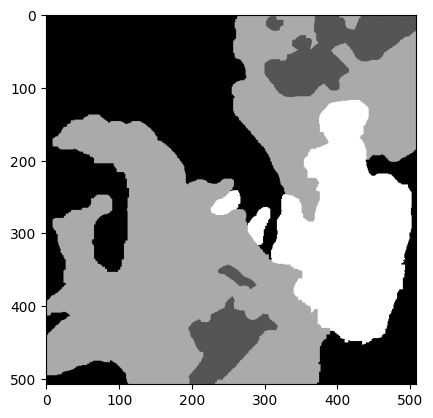

2025-10-08 13:11:34,620 __main__ INFO:	Tensor:			label1_2 unsqueeze
2025-10-08 13:11:34,621 __main__ INFO:	Output Datatype:	torch.float32
2025-10-08 13:11:34,622 __main__ INFO:	Output Shape:		torch.Size([1, 318, 318])
2025-10-08 13:11:34,623 __main__ INFO:	Output Size:		torch.Size([1, 318, 318])
2025-10-08 13:11:34,624 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-08 13:11:34,625 __main__ INFO:	Tensor:			label1_2 squeeze
2025-10-08 13:11:34,627 __main__ INFO:	Output Datatype:	torch.float32
2025-10-08 13:11:34,628 __main__ INFO:	Output Shape:		torch.Size([318, 318])
2025-10-08 13:11:34,629 __main__ INFO:	Output Size:		torch.Size([318, 318])
2025-10-08 13:11:34,631 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-08 13:11:34,633 __main__ INFO:	The image resolution is (318, 318)
2025-10-08 13:11:34,633 __main__ INFO:	The number of colour channels are 1


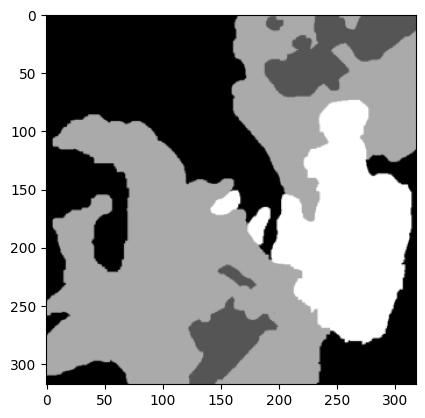

2025-10-08 13:11:34,939 __main__ INFO:	Tensor:			label1_2
2025-10-08 13:11:34,942 __main__ INFO:	Output Datatype:	torch.float32
2025-10-08 13:11:34,946 __main__ INFO:	Output Shape:		torch.Size([318, 318])
2025-10-08 13:11:34,955 __main__ INFO:	Output Size:		torch.Size([318, 318])
2025-10-08 13:11:34,955 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



In [104]:
import torchvision
# torchvision.transforms.Resize(
#     size,
#     interpolation = InterpolationMode.BILINEAR,
#     max_size=None,
#     antialias=True
# )

label1  = test_label[1][:][:]
# test = label1.torchvision.transforms.Resize(size = (508, 508))

# change = torchvision.transforms.Compose([
#     #torchvision.transforms.RandomResizedCrop(size=(224, 224), antialias=True),
#     torchvision.transforms.Resize(size = [320, 320])
# ])
# img = change(label1)

# tensor_info(img, "img")


pred = u_net_arch(test_img[1][:][:][:])
# tensor_info(pred, "pred")
pred = torch.squeeze(pred)
# tensor_info(pred, "pred + squeeze")

tensor_info(label1, "label1")

# label1_1 = label1.reshape([254, 1016])
# tensor_info(label1_1, "label1_1")

import torchvision.transforms.functional as F

mash_colour_channel(label1.unsqueeze(0)) #

label1_2 = F.resize(label1.unsqueeze(0), size = (318, 318))
tensor_info(label1_2, "label1_2 unsqueeze")

label1_2 = label1_2.squeeze(0).squeeze(0)
tensor_info(label1_2, "label1_2 squeeze")

mash_colour_channel(label1_2.unsqueeze(0)) #

tensor_info(label1_2, "label1_2")


# img = torch.reshape(pred, (508, 508))
# tensor_info(label1, "label1")
# tensor_info(img, "img")

In [ ]:
u_net_arch.eval()

# Making a prediction - use to evaluate the validity of the dataset
with torch.inference_mode():
  label_preds = u_net_arch(img_test)

# create graphical method of visualising code

In [ ]:
# Print off images and their respective dimensions
"""
# Visualising the results along with their respective dimensions

# Print off image with the colour channels combined
# First Image
mash_colour_channel(s2_l1c_data_tensor) # Original image

# Encoder Images
mash_colour_channel(A_pooled)
mash_colour_channel(B_pooled)
mash_colour_channel(C_pooled)
mash_colour_channel(D_pooled)

mash_colour_channel(E_bottleneck)

# Decoder Images
mash_colour_channel(D_deconv)
mash_colour_channel(C_deconv)
mash_colour_channel(B_deconv)
mash_colour_channel(A_deconv)

# Final image
mash_colour_channel(Final_output)

# Encoder
tensor_info(s2_l1c_data_tensor, "layer 0 - s2_l1c_data_tensor")
tensor_info(A_concat, "encoder_layer_0.5 - A_concat")
tensor_info(A_pooled, "encoder_layer_1 - A_pooled")
tensor_info(B_concat, "encoder_layer_1.5 - B_concat")
tensor_info(B_pooled, "encoder_layer_2 - B_pooled")
tensor_info(C_concat, "encoder_layer_2.5 - C_concat")
tensor_info(C_pooled, "encoder_layer_3 - C_pooled")
tensor_info(D_concat, "encoder_layer_4.5 - D_concat")
tensor_info(D_pooled, "encoder_layer_4 - D_pooled") # size [208, 28, 28] - final layer

tensor_info(E_bottleneck, "[BOTTLENECK] encoder_layer_5")

# Decoder
tensor_info(D_deconv, "decoder_layer_4 - D_deconv")
tensor_info(C_deconv, "encoder_layer_3 - C_deconv")
tensor_info(B_deconv, "encoder_layer_2 - B_deconv")
tensor_info(A_deconv, "encoder_layer_1 - A_deconv")
tensor_info(Final_output, "Final output")
"""

## todo:

main requirements:
1. *work out how to transfer images and visualise progress*
2. determine required images and what I should use
---
Datahandling:

1. > Need to determine how to import multiple datavalues
2. > Need to determine how many training and testing datasets there are
3. > Need to determine method of seperating datasets
4. > Need to determine if subset / SUB_DATA methodology works.

Do I need to create a proper datahandler?

---

3. being to save progress with model fitting
4. make the model tech agnostic
5. Get a logger setup - requires a working file directory
```
import logging
self.logger = logging.getLogger(__name__)
```
## todo big picture:
1. **DONE!** get rough model working
2. **DONE!** build the Unet model

##Useful knowledge:
1. keyboard shortcut to comment and uncomment out things is ctrl + "/"
2. The U-net model requires that the encoder/decoder colour channel follows the following pattern: 1 - 64 - 128 - 256 - 512
3. Refer to "https://stackoverflow.com/questions/57530038/concatenation-step-of-u-net-for-unequal-number-of-channels" for more information

## CloudSEN12+ dataset information:
(Further information about CloudSEN12+ dataset)

1. The Huggingface website: https://huggingface.co/datasets/tacofoundation/cloudsen12
Explains the overall picture of the dataset types

2. https://www.scidb.cn/en/detail?dataSetId=2036f4657b094edfbb099053d6024b08&version=V1
Explains historical dataset formatting - we are interested in  p509 has some further details. Investigate: *p509-> high -> train*

## Additional References:

Sam Hall's References:
- OBAI Cloud Detection tutorial: https://source.coop/radiantearth/cloud-cover-detection-challenge
- OBAI recommendations independent of ECSS: https://ieeexplore.ieee.org/document/10558221